### Training a Random Forest Regressor model (ranks)
Training a random forest regressor that predicts FPL points for the upcoming GW for players. This is a general model, and uses position as one of the predictors. A future step might be to produce a separate model for each position so that position-specific features can be better considered.

**NEW**: this model intends to predict points *ranking* rather than the exact number of points. As in, for each gameweek, players are given a ranking based on how many points they scored. The more points they scored, the higher their ranking. Players with the same points scored will get the same rank. The model focuses on predicting players who are most likely to produce point hauls in the upcoming gameweek. 

Rolling game statistics are key to the model - they will be computed on the previous three games for each player, and used as predictor features.

In [102]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from itertools import product
from scipy.stats import kendalltau
from random import sample
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
data = pd.read_csv("final_data_official.csv")
data

,name,club,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,team_a_score,...,ict_index,value,transfers_balance,selected,transfers_in,transfers_out,position,season,opponent_team_name,result
0,Aaron Cresswell,West Ham United,454,10,4,0,False,2016-08-15 19:00:00+00:00,2.0,1.0,...,0.0,55,0,14023,0,0,Defender,2016/2017,Chelsea,L
1,Aaron Lennon,Everton,142,3,17,1,True,2016-08-13 14:00:00+00:00,1.0,1.0,...,0.9,60,0,13918,0,0,Midfielder,2016/2017,Tottenham Hotspur,D
2,Abdoulaye Doucouré,Watford,482,7,13,0,False,2016-08-13 14:00:00+00:00,1.0,1.0,...,0.0,50,0,1051,0,0,Midfielder,2016/2017,Southampton,D
3,Adam Forshaw,Middlesbrough,286,6,14,1,True,2016-08-13 14:00:00+00:00,1.0,1.0,...,0.3,45,0,2723,0,0,Midfielder,2016/2017,Stoke City,D
4,Adam Lallana,Liverpool,205,8,1,11,False,2016-08-14 15:00:00+00:00,3.0,4.0,...,14.2,70,0,155525,0,0,Midfielder,2016/2017,Arsenal,W
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109075,Justin Hubner,Wolverhampton Wanderers,751,149,6,0,True,2023-12-05 19:30:00+00:00,1.0,0.0,...,0.0,40,344,555,375,31,Defender,2023/2024,Burnley,W
109076,Justin Hubner,Wolverhampton Wanderers,751,160,16,0,True,2023-12-09 15:00:00+00:00,1.0,1.0,...,0.0,40,329,1078,435,106,Defender,2023/2024,Nottingham Forest,D
109077,Justin Hubner,Wolverhampton Wanderers,751,170,19,0,False,2023-12-17 14:00:00+00:00,3.0,0.0,...,0.0,40,229,1583,418,189,Defender,2023/2024,West Ham United,L
109078,Justin Hubner,Wolverhampton Wanderers,751,180,7,0,True,2023-12-24 13:00:00+00:00,2.0,1.0,...,0.0,40,42,1763,197,155,Defender,2023/2024,Chelsea,W


In [3]:
# encoding categorical variables (club, opponent club, position, and result) as integers
club_encoder = LabelEncoder()
opp_encoder = LabelEncoder()
pos_encoder = LabelEncoder()
data["club_encoded"] = club_encoder.fit_transform(data["club"])
data["opponent_encoded"] = opp_encoder.fit_transform(data["opponent_team_name"])
data["position_encoded"] = pos_encoder.fit_transform(data["position"])
# there is inherent ordinality to results - W > D > L
result_mapping = {'W': 2, 'D': 1, 'L': 0}
data['result_encoded'] = data['result'].map(result_mapping)
data

,name,club,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,team_a_score,...,transfers_in,transfers_out,position,season,opponent_team_name,result,club_encoded,opponent_encoded,position_encoded,result_encoded
0,Aaron Cresswell,West Ham United,454,10,4,0,False,2016-08-15 19:00:00+00:00,2.0,1.0,...,0,0,Defender,2016/2017,Chelsea,L,31,6,0,0
1,Aaron Lennon,Everton,142,3,17,1,True,2016-08-13 14:00:00+00:00,1.0,1.0,...,0,0,Midfielder,2016/2017,Tottenham Hotspur,D,9,27,3,1
2,Abdoulaye Doucouré,Watford,482,7,13,0,False,2016-08-13 14:00:00+00:00,1.0,1.0,...,0,0,Midfielder,2016/2017,Southampton,D,29,23,3,1
3,Adam Forshaw,Middlesbrough,286,6,14,1,True,2016-08-13 14:00:00+00:00,1.0,1.0,...,0,0,Midfielder,2016/2017,Stoke City,D,19,24,3,1
4,Adam Lallana,Liverpool,205,8,1,11,False,2016-08-14 15:00:00+00:00,3.0,4.0,...,0,0,Midfielder,2016/2017,Arsenal,W,15,0,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109075,Justin Hubner,Wolverhampton Wanderers,751,149,6,0,True,2023-12-05 19:30:00+00:00,1.0,0.0,...,375,31,Defender,2023/2024,Burnley,W,32,5,0,2
109076,Justin Hubner,Wolverhampton Wanderers,751,160,16,0,True,2023-12-09 15:00:00+00:00,1.0,1.0,...,435,106,Defender,2023/2024,Nottingham Forest,D,32,21,0,1
109077,Justin Hubner,Wolverhampton Wanderers,751,170,19,0,False,2023-12-17 14:00:00+00:00,3.0,0.0,...,418,189,Defender,2023/2024,West Ham United,L,32,30,0,0
109078,Justin Hubner,Wolverhampton Wanderers,751,180,7,0,True,2023-12-24 13:00:00+00:00,2.0,1.0,...,197,155,Defender,2023/2024,Chelsea,W,32,6,0,2


In [4]:
# function that gives ranking to players for points scored by gw - the more the points, the higher the ranking
def rank_gw_points(group, col_to_rank, rank_col): 
    # method="min" means that if two players this gw have the same number of points, they will have the same rank
    ranks = group[col_to_rank].rank(method="min")
    group[rank_col] = ranks

    return group

In [5]:
data["kickoff_time"] = pd.to_datetime(data["kickoff_time"])
gw_ranks = data.groupby(["round", "season"]).apply(lambda x: rank_gw_points(x, "total_points", "points_rank"))
gw_ranks

name                    club  \
round season                                                              
1     2016/2017 0               Aaron Cresswell         West Ham United   
                1                  Aaron Lennon                 Everton   
                2            Abdoulaye Doucouré                 Watford   
                3                  Adam Forshaw           Middlesbrough   
                4                  Adam Lallana               Liverpool   
...                                         ...                     ...   
38    2022/2023 95510              Oliver Skipp       Tottenham Hotspur   
                95511            Ryan Sessegnon       Tottenham Hotspur   
                95512              Ashley Young             Aston Villa   
                95513  Jeremy Sarmiento Morante  Brighton & Hove Albion   
                95514            Philip Billing             Bournemouth   

                       element  fixture  opponent_team  total_points  \
round season                                                           
1     2016/2017 0          454       10              4             0   
                1          142        3             17             1   
                2          482        7             13             0   
                3          286        6             14             1   
                4          205        8              1            11   
...                        ...      ...            ...           ...   
38    2022/2023 95510      441      377             11             2   
                95511      436      377             11             0   
                95512      538      372              5             0   
                95513      119      372              2             0   
                95514       70      376              8             2   

                       was_home              kickoff_time  team_h_score  \
round season                                                              
1     2016/2017 0         False 2016-08-15 19:00:00+00:00           2.0   
                1          True 2016-08-13 14:00:00+00:00           1.0   
                2         False 2016-08-13 14:00:00+00:00           1.0   
                3          True 2016-08-13 14:00:00+00:00           1.0   
                4         False 2016-08-14 15:00:00+00:00           3.0   
...                         ...                       ...           ...   
38    2022/2023 95510     False 2023-05-28 15:30:00+00:00           1.0   
                95511     False 2023-05-28 15:30:00+00:00           1.0   
                95512      True 2023-05-28 15:30:00+00:00           2.0   
                95513     False 2023-05-28 15:30:00+00:00           2.0   
                95514     False 2023-05-28 15:30:00+00:00           1.0   

                       team_a_score  ...  transfers_out    position  \
round season                         ...                              
1     2016/2017 0               1.0  ...              0    Defender   
                1               1.0  ...              0  Midfielder   
                2               1.0  ...              0  Midfielder   
                3               1.0  ...              0  Midfielder   
                4               4.0  ...              0  Midfielder   
...                             ...  ...            ...         ...   
38    2022/2023 95510           4.0  ...            642  Midfielder   
                95511           4.0  ...            190  Midfielder   
                95512           1.0  ...           2668    Defender   
                95513           1.0  ...             39     Forward   
                95514           0.0  ...          19097  Midfielder   

                          season      opponent_team_name  result  \
round season                                                       
1     2016/2017 0      2016/2017                 Chelsea       L   
                1      201

In [6]:
gw_ranks = gw_ranks.droplevel(["round", "season"])
gw_ranks

,name,club,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,team_a_score,...,transfers_out,position,season,opponent_team_name,result,club_encoded,opponent_encoded,position_encoded,result_encoded,points_rank
0,Aaron Cresswell,West Ham United,454,10,4,0,False,2016-08-15 19:00:00+00:00,2.0,1.0,...,0,Defender,2016/2017,Chelsea,L,31,6,0,0,1.0
1,Aaron Lennon,Everton,142,3,17,1,True,2016-08-13 14:00:00+00:00,1.0,1.0,...,0,Midfielder,2016/2017,Tottenham Hotspur,D,9,27,3,1,81.0
2,Abdoulaye Doucouré,Watford,482,7,13,0,False,2016-08-13 14:00:00+00:00,1.0,1.0,...,0,Midfielder,2016/2017,Southampton,D,29,23,3,1,1.0
3,Adam Forshaw,Middlesbrough,286,6,14,1,True,2016-08-13 14:00:00+00:00,1.0,1.0,...,0,Midfielder,2016/2017,Stoke City,D,19,24,3,1,81.0
4,Adam Lallana,Liverpool,205,8,1,11,False,2016-08-14 15:00:00+00:00,3.0,4.0,...,0,Midfielder,2016/2017,Arsenal,W,15,0,3,2,192.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95510,Oliver Skipp,Tottenham Hotspur,441,377,11,2,False,2023-05-28 15:30:00+00:00,1.0,4.0,...,642,Midfielder,2022/2023,Leeds United,W,28,12,3,2,601.0
95511,Ryan Sessegnon,Tottenham Hotspur,436,377,11,0,False,2023-05-28 15:30:00+00:00,1.0,4.0,...,190,Midfielder,2022/2023,Leeds United,W,28,12,3,2,6.0
95512,Ashley Young,Aston Villa,538,372,5,0,True,2023-05-28 15:30:00+00:00,2.0,1.0,...,2668,Defender,2022/2023,Brighton & Hove Albion,W,1,4,0,2,6.0
95513,Jeremy Sarmiento Morante,Brighton & Hove Albion,119,372,2,0,False,2023-05-28 15:30:00+00:00,2.0,1.0,...,39,Forward,2022/2023,Aston Villa,L,4,1,1,0,6.0


In [7]:
gw_ranks.index = range(gw_ranks.shape[0])
gw_ranks

,name,club,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,team_a_score,...,transfers_out,position,season,opponent_team_name,result,club_encoded,opponent_encoded,position_encoded,result_encoded,points_rank
0,Aaron Cresswell,West Ham United,454,10,4,0,False,2016-08-15 19:00:00+00:00,2.0,1.0,...,0,Defender,2016/2017,Chelsea,L,31,6,0,0,1.0
1,Aaron Lennon,Everton,142,3,17,1,True,2016-08-13 14:00:00+00:00,1.0,1.0,...,0,Midfielder,2016/2017,Tottenham Hotspur,D,9,27,3,1,81.0
2,Abdoulaye Doucouré,Watford,482,7,13,0,False,2016-08-13 14:00:00+00:00,1.0,1.0,...,0,Midfielder,2016/2017,Southampton,D,29,23,3,1,1.0
3,Adam Forshaw,Middlesbrough,286,6,14,1,True,2016-08-13 14:00:00+00:00,1.0,1.0,...,0,Midfielder,2016/2017,Stoke City,D,19,24,3,1,81.0
4,Adam Lallana,Liverpool,205,8,1,11,False,2016-08-14 15:00:00+00:00,3.0,4.0,...,0,Midfielder,2016/2017,Arsenal,W,15,0,3,2,192.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109075,Oliver Skipp,Tottenham Hotspur,441,377,11,2,False,2023-05-28 15:30:00+00:00,1.0,4.0,...,642,Midfielder,2022/2023,Leeds United,W,28,12,3,2,601.0
109076,Ryan Sessegnon,Tottenham Hotspur,436,377,11,0,False,2023-05-28 15:30:00+00:00,1.0,4.0,...,190,Midfielder,2022/2023,Leeds United,W,28,12,3,2,6.0
109077,Ashley Young,Aston Villa,538,372,5,0,True,2023-05-28 15:30:00+00:00,2.0,1.0,...,2668,Defender,2022/2023,Brighton & Hove Albion,W,1,4,0,2,6.0
109078,Jeremy Sarmiento Morante,Brighton & Hove Albion,119,372,2,0,False,2023-05-28 15:30:00+00:00,2.0,1.0,...,39,Forward,2022/2023,Aston Villa,L,4,1,1,0,6.0


In [8]:
temp = gw_ranks[gw_ranks["season"] == "2023/2024"]
temp = temp[["name", "club", "round", "total_points", "points_rank"]]
temp = temp[temp["round"] == 19]
# max(temp["points_rank"])
# temp[temp["points_rank"] == max(temp["points_rank"])]
temp.nlargest(10, "points_rank")

,name,club,round,total_points,points_rank
55803,Chris Wood,Nottingham Forest,19,17,751.0
55359,João Pedro Junqueira de Jesus,Brighton & Hove Albion,19,16,750.0
55918,Konstantinos Mavropanos,West Ham United,19,15,749.0
55695,Alejandro Garnacho,Manchester United,19,14,747.0
55932,Hwang Hee-chan,Wolverhampton Wanderers,19,14,747.0
55246,Leander Dendoncker,Aston Villa,19,13,745.0
55657,Bernardo Veiga de Carvalho e Silva,Manchester City,19,13,745.0
55769,Anthony Elanga,Nottingham Forest,19,10,743.0
55894,Alphonse Areola,West Ham United,19,10,743.0
55289,Norberto Murara Neto,Bournemouth,19,9,736.0


In [9]:
# to compute rolling statistics, we group the dataset by player
players_grp = gw_ranks.groupby(["name"])
haaland = players_grp.get_group("Erling Haaland")
haaland.head(10)

,name,club,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,team_a_score,...,transfers_out,position,season,opponent_team_name,result,club_encoded,opponent_encoded,position_encoded,result_encoded,points_rank
1508,Erling Haaland,Manchester City,318,10,19,13,False,2022-08-07 15:30:00+00:00,0.0,2.0,...,0,Forward,2022/2023,West Ham United,W,17,30,1,2,566.0
2405,Erling Haaland,Manchester City,355,1,6,13,False,2023-08-11 19:00:00+00:00,0.0,3.0,...,0,Forward,2023/2024,Burnley,W,17,5,1,2,650.0
4294,Erling Haaland,Manchester City,318,17,3,5,True,2022-08-13 14:00:00+00:00,4.0,0.0,...,29876,Forward,2022/2023,Bournemouth,W,17,2,1,2,513.0
5132,Erling Haaland,Manchester City,355,16,15,2,True,2023-08-19 19:00:00+00:00,1.0,0.0,...,28829,Forward,2023/2024,Newcastle United,W,17,19,1,2,449.0
7060,Erling Haaland,Manchester City,318,28,15,6,False,2022-08-21 15:30:00+00:00,3.0,3.0,...,141547,Forward,2022/2023,Newcastle United,D,17,19,1,1,534.0
7992,Erling Haaland,Manchester City,355,30,17,4,False,2023-08-27 13:00:00+00:00,1.0,2.0,...,26792,Forward,2023/2024,Sheffield United,W,17,22,1,2,615.0
9971,Erling Haaland,Manchester City,318,37,7,17,True,2022-08-27 14:00:00+00:00,4.0,2.0,...,132280,Forward,2022/2023,Crystal Palace,W,17,7,1,2,596.0
10920,Erling Haaland,Manchester City,355,39,10,20,True,2023-09-02 14:00:00+00:00,5.0,1.0,...,26012,Forward,2023/2024,Fulham,W,17,9,1,2,696.0
12938,Erling Haaland,Manchester City,318,49,16,17,True,2022-08-31 18:30:00+00:00,6.0,0.0,...,50249,Forward,2022/2023,Nottingham Forest,W,17,21,1,2,604.0
13899,Erling Haaland,Manchester City,355,49,19,6,False,2023-09-16 14:00:00+00:00,1.0,3.0,...,14174,Forward,2023/2024,West Ham United,W,17,30,1,2,667.0


In [10]:
# function that computes assigns rolling averages for `cols` for each group (each player)
def rolling_averages(group, cols, new_cols):
    # sort all data by kickoff time, earliest to latest (ascending)
    group = group.sort_values(["kickoff_time"])
    # a mask that identifies where the season changes
    season_mask = group["season"] != group["season"].shift(1)
    # a cumulative count of season changes
    change_count = season_mask.cumsum()
    # rolling averages separately for each season - window resets if season changes
    group[new_cols] = (
        group.groupby(change_count)[cols]
        .rolling(window=3, closed="left", min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )
    group = group.dropna(subset=new_cols)
    return group

In [11]:
def rolling_averages_old(group, cols, new_cols):
    # sort data by date, ascending
    group = group.sort_values(["kickoff_time"])
    # compute rolling average - note that `closed = left` means that future data isn't used
    rolling_stats = group[cols].rolling(window = 3, closed = "left", min_periods=1).mean()
    # assign the rolling statistics back to the original dataframe
    group[new_cols] = rolling_stats
    # drop the observations containing missing values to prevent propagation of NaN values
    group = group.dropna(subset = new_cols)
    return group

In [12]:
data.columns

Index(['name', 'club', 'element', 'fixture', 'opponent_team', 'total_points',
       'was_home', 'kickoff_time', 'team_h_score', 'team_a_score', 'round',
       'minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded',
       'own_goals', 'penalties_saved', 'penalties_missed', 'yellow_cards',
       'red_cards', 'saves', 'bonus', 'bps', 'influence', 'creativity',
       'threat', 'ict_index', 'value', 'transfers_balance', 'selected',
       'transfers_in', 'transfers_out', 'position', 'season',
       'opponent_team_name', 'result', 'club_encoded', 'opponent_encoded',
       'position_encoded', 'result_encoded'],
      dtype='object')

In [13]:
# the cols we want to compute rolling averages for 
cols = ["assists", "clean_sheets", "goals_scored", "goals_conceded", "ict_index", "bps", 
        "minutes", "red_cards", "saves", "selected", "transfers_balance", 
        "result_encoded", "value", "total_points", "points_rank"]
# append "_rolling" onto each column name
new_cols = [f"{col}_rolling" for col in cols]

In [14]:
rolling_averages(haaland, cols, new_cols).head(20)

,name,club,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,team_a_score,...,bps_rolling,minutes_rolling,red_cards_rolling,saves_rolling,selected_rolling,transfers_balance_rolling,result_encoded_rolling,value_rolling,total_points_rolling,points_rank_rolling
4294,Erling Haaland,Manchester City,318,17,3,5,True,2022-08-13 14:00:00+00:00,4.0,0.0,...,48.000000,77.000000,0.0,0.0,3.398599e+06,0.000000,2.000000,115.000000,13.000000,566.000000
7060,Erling Haaland,Manchester City,318,28,15,6,False,2022-08-21 15:30:00+00:00,3.0,3.0,...,32.000000,75.000000,0.0,0.0,4.312434e+06,556968.500000,2.000000,115.500000,9.000000,539.500000
9971,Erling Haaland,Manchester City,318,37,7,17,True,2022-08-27 14:00:00+00:00,4.0,2.0,...,30.666667,80.000000,0.0,0.0,4.767158e+06,447084.666667,1.666667,116.000000,8.000000,537.666667
12938,Erling Haaland,Manchester City,318,49,16,17,True,2022-08-31 18:30:00+00:00,6.0,0.0,...,39.000000,82.000000,0.0,0.0,5.623560e+06,480293.000000,1.666667,116.666667,9.333333,547.666667
15937,Erling Haaland,Manchester City,318,51,2,9,False,2022-09-03 16:30:00+00:00,1.0,1.0,...,60.666667,80.333333,0.0,0.0,6.146089e+06,317286.000000,1.666667,117.333333,13.333333,578.000000
21437,Erling Haaland,Manchester City,318,80,20,6,False,2022-09-17 11:30:00+00:00,0.0,3.0,...,62.000000,80.333333,0.0,0.0,6.847716e+06,502273.333333,1.666667,118.000000,14.333333,601.333333
24330,Erling Haaland,Manchester City,318,88,14,23,True,2022-10-02 13:00:00+00:00,6.0,3.0,...,47.333333,82.666667,0.0,0.0,7.660872e+06,514079.000000,1.666667,119.000000,10.666667,534.333333
27409,Erling Haaland,Manchester City,318,97,17,6,True,2022-10-08 14:00:00+00:00,4.0,0.0,...,54.333333,90.000000,0.0,0.0,8.245741e+06,337170.333333,1.666667,120.000000,12.666667,544.333333
30432,Erling Haaland,Manchester City,318,106,12,2,False,2022-10-16 15:30:00+00:00,1.0,0.0,...,51.333333,90.000000,0.0,0.0,8.620385e+06,167291.666667,2.000000,121.000000,11.666667,538.333333
36529,Erling Haaland,Manchester City,318,125,5,13,True,2022-10-22 14:00:00+00:00,3.0,1.0,...,41.000000,90.000000,0.0,0.0,8.814516e+06,135821.666667,1.333333,121.666667,10.333333,561.666667


In [15]:
player_rolling = gw_ranks.groupby("name").apply(lambda x: rolling_averages(x, cols, new_cols))

In [16]:
player_rolling

name                    club  element  \
name                                                                     
Aaron Connolly 3122    Aaron Connolly  Brighton & Hove Albion       78   
               5861    Aaron Connolly  Brighton & Hove Albion       78   
               8741    Aaron Connolly  Brighton & Hove Albion       78   
               11679   Aaron Connolly  Brighton & Hove Albion       78   
               14671   Aaron Connolly  Brighton & Hove Albion       78   
...                               ...                     ...      ...   
Ørjan Nyland   97541     Ørjan Nyland             Aston Villa       35   
               97542     Ørjan Nyland             Aston Villa       35   
               100499    Ørjan Nyland             Aston Villa       35   
               104009    Ørjan Nyland             Aston Villa       35   
               107067    Ørjan Nyland             Aston Villa       35   

                       fixture  opponent_team  total_points  was_home  \
name                                                                    
Aaron Connolly 3122         16             14             8     False   
               5861         19             13             2      True   
               8741         32              7             2     False   
               11679        40              6             4     False   
               14671        51             18             0      True   
...                        ...            ...           ...       ...   
Ørjan Nyland   97541       340             13             0      True   
               97542       180              7             0      True   
               100499      355              6             0     False   
               104009      367             17             0     False   
               107067      370              5             0      True   

                                   kickoff_time  team_h_score  team_a_score  \
name                                                                          
Aaron Connolly 3122   2020-09-20 13:00:00+00:00           0.0           3.0   
               5861   2020-09-26 11:30:00+00:00           2.0           3.0   
               8741   2020-10-03 14:00:00+00:00           4.0           2.0   
               11679  2020-10-18 13:00:00+00:00           1.0           1.0   
               14671  2020-10-26 17:30:00+00:00           1.0           1.0   
...                                         ...           ...           ...   
Ørjan Nyland   97541  2021-05-09 13:05:00+00:00           1.0           3.0   
               97542  2021-05-13 17:00:00+00:00           0.0           0.0   
               100499 2021-05-16 11:00:00+00:00           3.0           2.0   
               104009 2021-05-19 17:00:00+00:00           1.0           2.0   
               107067 2021-05-23 15:00:00+00:00           2.0           1.0   

                       ...  bps_rolling  minutes_rolling  red_cards_rolling  \
name                   ...                                                    
Aaron Connolly 3122    ...    -3.000000        45.000000                0.0   
               5861    ...    12.000000        67.000000                0.0   
               8741    ...     8.666667        69.000000                0.0   
               11679   ...    12.000000        75.666667                0.0   
               14671   ...     7.333333        50.000000                0.0   
...                    ...          ...              ...                ...   
Ørjan Nyland   97541   ...     0.000000         0.000000                0.0   
               97542   ...     0.000000         0.000000                0.0   
               100499  ...     0.000000         0.000000                0.0   
               104009  ...     0.000000         0.000000                0.0   
               107067  ...     0.000000         0.000000                0.0   

                       saves_rolling  selected_rolling  \
name  

In [17]:
player_rolling = player_rolling.droplevel("name")
player_rolling

,name,club,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,team_a_score,...,bps_rolling,minutes_rolling,red_cards_rolling,saves_rolling,selected_rolling,transfers_balance_rolling,result_encoded_rolling,value_rolling,total_points_rolling,points_rank_rolling
3122,Aaron Connolly,Brighton & Hove Albion,78,16,14,8,False,2020-09-20 13:00:00+00:00,0.0,3.0,...,-3.000000,45.000000,0.0,0.0,32205.000000,0.000000,0.000000,55.0,1.000000,212.000000
5861,Aaron Connolly,Brighton & Hove Albion,78,19,13,2,True,2020-09-26 11:30:00+00:00,2.0,3.0,...,12.000000,67.000000,0.0,0.0,33617.500000,-580.500000,1.000000,55.0,4.500000,361.000000
8741,Aaron Connolly,Brighton & Hove Albion,78,32,7,2,False,2020-10-03 14:00:00+00:00,4.0,2.0,...,8.666667,69.000000,0.0,0.0,40863.666667,4121.666667,0.666667,55.0,3.666667,369.000000
11679,Aaron Connolly,Brighton & Hove Albion,78,40,6,4,False,2020-10-18 13:00:00+00:00,1.0,1.0,...,12.000000,75.666667,0.0,0.0,48503.666667,3684.666667,0.666667,55.0,4.000000,433.333333
14671,Aaron Connolly,Brighton & Hove Albion,78,51,18,0,True,2020-10-26 17:30:00+00:00,1.0,1.0,...,7.333333,50.000000,0.0,0.0,52418.333333,1074.333333,0.333333,55.0,2.666667,435.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97541,Ørjan Nyland,Aston Villa,35,340,13,0,True,2021-05-09 13:05:00+00:00,1.0,3.0,...,0.000000,0.000000,0.0,0.0,281394.333333,-2122.333333,1.000000,40.0,0.000000,3.666667
97542,Ørjan Nyland,Aston Villa,35,180,7,0,True,2021-05-13 17:00:00+00:00,0.0,0.0,...,0.000000,0.000000,0.0,0.0,278999.000000,-2346.666667,1.000000,40.0,0.000000,3.333333
100499,Ørjan Nyland,Aston Villa,35,355,6,0,False,2021-05-16 11:00:00+00:00,3.0,2.0,...,0.000000,0.000000,0.0,0.0,277527.000000,-2471.000000,1.000000,40.0,0.000000,3.333333
104009,Ørjan Nyland,Aston Villa,35,367,17,0,False,2021-05-19 17:00:00+00:00,1.0,2.0,...,0.000000,0.000000,0.0,0.0,276053.000000,-2426.000000,0.333333,40.0,0.000000,2.333333


In [18]:
player_rolling.index = range(player_rolling.shape[0])
player_rolling

,name,club,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,team_a_score,...,bps_rolling,minutes_rolling,red_cards_rolling,saves_rolling,selected_rolling,transfers_balance_rolling,result_encoded_rolling,value_rolling,total_points_rolling,points_rank_rolling
0,Aaron Connolly,Brighton & Hove Albion,78,16,14,8,False,2020-09-20 13:00:00+00:00,0.0,3.0,...,-3.000000,45.000000,0.0,0.0,32205.000000,0.000000,0.000000,55.0,1.000000,212.000000
1,Aaron Connolly,Brighton & Hove Albion,78,19,13,2,True,2020-09-26 11:30:00+00:00,2.0,3.0,...,12.000000,67.000000,0.0,0.0,33617.500000,-580.500000,1.000000,55.0,4.500000,361.000000
2,Aaron Connolly,Brighton & Hove Albion,78,32,7,2,False,2020-10-03 14:00:00+00:00,4.0,2.0,...,8.666667,69.000000,0.0,0.0,40863.666667,4121.666667,0.666667,55.0,3.666667,369.000000
3,Aaron Connolly,Brighton & Hove Albion,78,40,6,4,False,2020-10-18 13:00:00+00:00,1.0,1.0,...,12.000000,75.666667,0.0,0.0,48503.666667,3684.666667,0.666667,55.0,4.000000,433.333333
4,Aaron Connolly,Brighton & Hove Albion,78,51,18,0,True,2020-10-26 17:30:00+00:00,1.0,1.0,...,7.333333,50.000000,0.0,0.0,52418.333333,1074.333333,0.333333,55.0,2.666667,435.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105561,Ørjan Nyland,Aston Villa,35,340,13,0,True,2021-05-09 13:05:00+00:00,1.0,3.0,...,0.000000,0.000000,0.0,0.0,281394.333333,-2122.333333,1.000000,40.0,0.000000,3.666667
105562,Ørjan Nyland,Aston Villa,35,180,7,0,True,2021-05-13 17:00:00+00:00,0.0,0.0,...,0.000000,0.000000,0.0,0.0,278999.000000,-2346.666667,1.000000,40.0,0.000000,3.333333
105563,Ørjan Nyland,Aston Villa,35,355,6,0,False,2021-05-16 11:00:00+00:00,3.0,2.0,...,0.000000,0.000000,0.0,0.0,277527.000000,-2471.000000,1.000000,40.0,0.000000,3.333333
105564,Ørjan Nyland,Aston Villa,35,367,17,0,False,2021-05-19 17:00:00+00:00,1.0,2.0,...,0.000000,0.000000,0.0,0.0,276053.000000,-2426.000000,0.333333,40.0,0.000000,2.333333


In [19]:
player_rolling = player_rolling.drop_duplicates()
player_rolling

,name,club,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,team_a_score,...,bps_rolling,minutes_rolling,red_cards_rolling,saves_rolling,selected_rolling,transfers_balance_rolling,result_encoded_rolling,value_rolling,total_points_rolling,points_rank_rolling
0,Aaron Connolly,Brighton & Hove Albion,78,16,14,8,False,2020-09-20 13:00:00+00:00,0.0,3.0,...,-3.000000,45.000000,0.0,0.0,32205.000000,0.000000,0.000000,55.0,1.000000,212.000000
1,Aaron Connolly,Brighton & Hove Albion,78,19,13,2,True,2020-09-26 11:30:00+00:00,2.0,3.0,...,12.000000,67.000000,0.0,0.0,33617.500000,-580.500000,1.000000,55.0,4.500000,361.000000
2,Aaron Connolly,Brighton & Hove Albion,78,32,7,2,False,2020-10-03 14:00:00+00:00,4.0,2.0,...,8.666667,69.000000,0.0,0.0,40863.666667,4121.666667,0.666667,55.0,3.666667,369.000000
3,Aaron Connolly,Brighton & Hove Albion,78,40,6,4,False,2020-10-18 13:00:00+00:00,1.0,1.0,...,12.000000,75.666667,0.0,0.0,48503.666667,3684.666667,0.666667,55.0,4.000000,433.333333
4,Aaron Connolly,Brighton & Hove Albion,78,51,18,0,True,2020-10-26 17:30:00+00:00,1.0,1.0,...,7.333333,50.000000,0.0,0.0,52418.333333,1074.333333,0.333333,55.0,2.666667,435.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105561,Ørjan Nyland,Aston Villa,35,340,13,0,True,2021-05-09 13:05:00+00:00,1.0,3.0,...,0.000000,0.000000,0.0,0.0,281394.333333,-2122.333333,1.000000,40.0,0.000000,3.666667
105562,Ørjan Nyland,Aston Villa,35,180,7,0,True,2021-05-13 17:00:00+00:00,0.0,0.0,...,0.000000,0.000000,0.0,0.0,278999.000000,-2346.666667,1.000000,40.0,0.000000,3.333333
105563,Ørjan Nyland,Aston Villa,35,355,6,0,False,2021-05-16 11:00:00+00:00,3.0,2.0,...,0.000000,0.000000,0.0,0.0,277527.000000,-2471.000000,1.000000,40.0,0.000000,3.333333
105564,Ørjan Nyland,Aston Villa,35,367,17,0,False,2021-05-19 17:00:00+00:00,1.0,2.0,...,0.000000,0.000000,0.0,0.0,276053.000000,-2426.000000,0.333333,40.0,0.000000,2.333333


In [20]:
player_rolling.to_csv("player_rolling_final.csv", index=False)

In [21]:
player_rolling.columns

Index(['name', 'club', 'element', 'fixture', 'opponent_team', 'total_points',
       'was_home', 'kickoff_time', 'team_h_score', 'team_a_score', 'round',
       'minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded',
       'own_goals', 'penalties_saved', 'penalties_missed', 'yellow_cards',
       'red_cards', 'saves', 'bonus', 'bps', 'influence', 'creativity',
       'threat', 'ict_index', 'value', 'transfers_balance', 'selected',
       'transfers_in', 'transfers_out', 'position', 'season',
       'opponent_team_name', 'result', 'club_encoded', 'opponent_encoded',
       'position_encoded', 'result_encoded', 'points_rank', 'assists_rolling',
       'clean_sheets_rolling', 'goals_scored_rolling',
       'goals_conceded_rolling', 'ict_index_rolling', 'bps_rolling',
       'minutes_rolling', 'red_cards_rolling', 'saves_rolling',
       'selected_rolling', 'transfers_balance_rolling',
       'result_encoded_rolling', 'value_rolling', 'total_points_rolling',
       'points

In [22]:
features = ["position_encoded", "club_encoded", "was_home", "opponent_encoded"] + new_cols
target = ["points_rank"]

In [23]:
features

['position_encoded',
 'club_encoded',
 'was_home',
 'opponent_encoded',
 'assists_rolling',
 'clean_sheets_rolling',
 'goals_scored_rolling',
 'goals_conceded_rolling',
 'ict_index_rolling',
 'bps_rolling',
 'minutes_rolling',
 'red_cards_rolling',
 'saves_rolling',
 'selected_rolling',
 'transfers_balance_rolling',
 'result_encoded_rolling',
 'value_rolling',
 'total_points_rolling',
 'points_rank_rolling']

In [24]:
# splitting the dataset into training, testing, and validation sets
seasons = np.unique(player_rolling["season"])
train_seasons = seasons[:4]
test_seasons = seasons[4:]
train = player_rolling[player_rolling["season"].isin(train_seasons)]
test = player_rolling[player_rolling["season"].isin(test_seasons)]
train_seasons, test_seasons, train.shape, test.shape

(array(['2016/2017', '2017/2018', '2020/2021', '2021/2022'], dtype=object),
 array(['2022/2023', '2023/2024'], dtype=object),
 (67168, 57),
 (38398, 57))

In [25]:
rf_reg = RandomForestRegressor(max_depth=10, min_samples_leaf=12, min_samples_split=30, n_estimators=600, n_jobs=-1, random_state=21)
rf_reg.fit(train[features], np.ravel(train[target]))

RandomForestRegressor(max_depth=10, min_samples_leaf=12, min_samples_split=30,
                      n_estimators=600, n_jobs=-1, random_state=21)

In [26]:
predictions = rf_reg.predict(test[features])

In [27]:
predictions

array([ 25.86932845,  19.56905896,  20.36698992, ..., 413.65726195,
       289.33008101, 125.33972154])

In [28]:
mae = mean_absolute_error(test[target], predictions)
mse = mean_squared_error(test[target], predictions)
rmse = mean_squared_error(test[target], predictions, squared=False)  # Pass squared=False to get RMSE
r2 = r2_score(test[target], predictions)
explained_variance = explained_variance_score(test[target], predictions)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')
print(f'Explained Variance: {explained_variance}')

MAE: 127.14565259125197
MSE: 38334.22429437446
RMSE: 195.7912773705061
R2 Score: 0.5182655996733332
Explained Variance: 0.519406140581862


In [29]:
with open("rank_rf_reg_model.pickle", "wb") as output:
    pickle.dump(rf_reg, output)

In [30]:
importances = dict(zip(features, rf_reg.feature_importances_))
sorted(importances.items(), key=lambda x:x[1], reverse=True)

[('points_rank_rolling', 0.8491256851897724),
 ('minutes_rolling', 0.023551092532923028),
 ('selected_rolling', 0.02323742446654376),
 ('value_rolling', 0.017146700092042066),
 ('transfers_balance_rolling', 0.016749977329346133),
 ('ict_index_rolling', 0.01533523800528359),
 ('total_points_rolling', 0.012105098507712757),
 ('bps_rolling', 0.008626211633700783),
 ('opponent_encoded', 0.00808955299110288),
 ('club_encoded', 0.00784945930219741),
 ('result_encoded_rolling', 0.005133052748693081),
 ('position_encoded', 0.005029972160464101),
 ('goals_conceded_rolling', 0.0036566806720840063),
 ('was_home', 0.0013962879393982774),
 ('clean_sheets_rolling', 0.0011429850741871796),
 ('assists_rolling', 0.0005148141727792857),
 ('saves_rolling', 0.00047370363677060127),
 ('goals_scored_rolling', 0.0004588289915905572),
 ('red_cards_rolling', 0.00037723455340807956)]

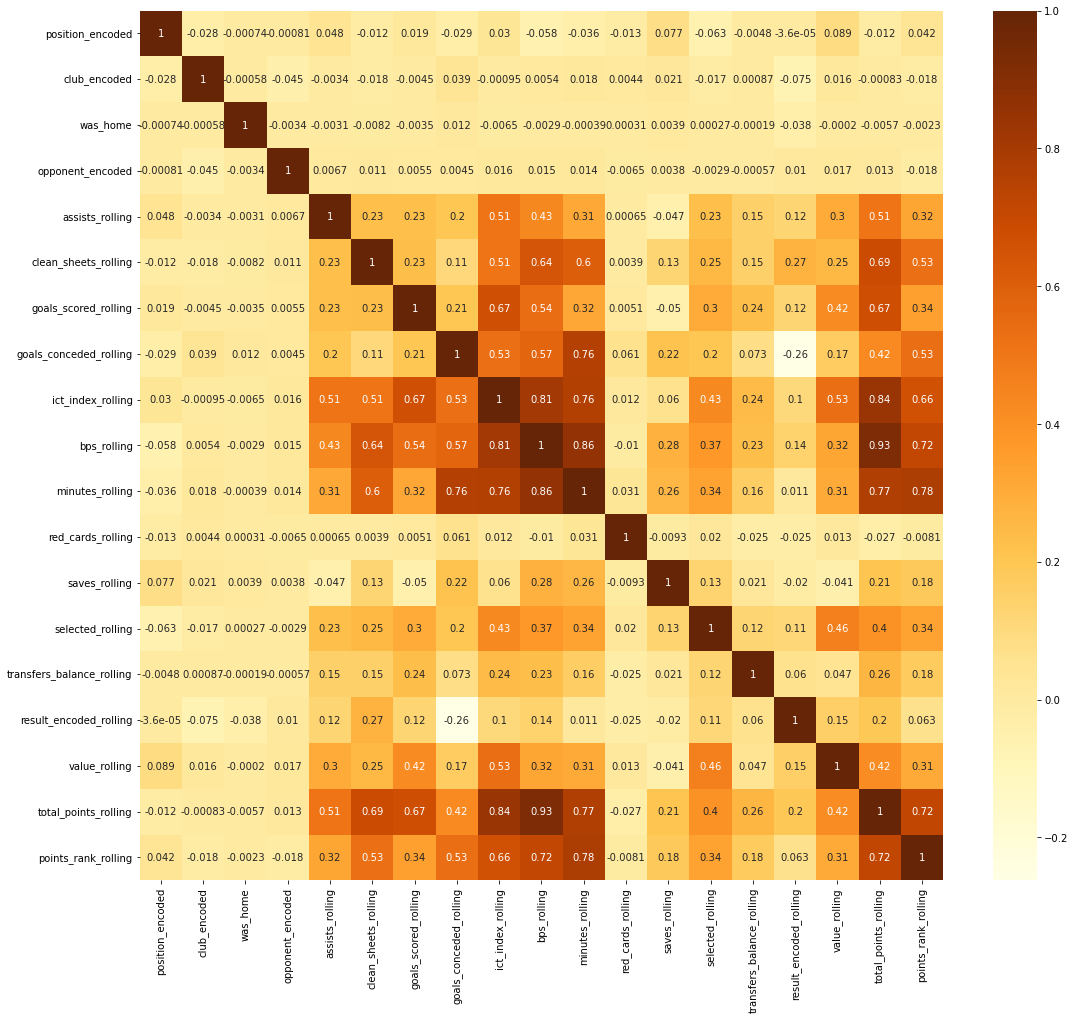

In [31]:
plt.figure(figsize=(18, 16))
sns.heatmap(player_rolling[features].corr(), annot = True, cmap="YlOrBr")
plt.show()

#### Evaluating accuracy / efficacy by comparing similarity of orderings
This is done using Kendall's tau correlation coefficient, which measures the *ordinal* association between two lists without considering magnitude. 

In [86]:
results = test.copy()
results["prediction"] = predictions
results

,name,club,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,team_a_score,...,minutes_rolling,red_cards_rolling,saves_rolling,selected_rolling,transfers_balance_rolling,result_encoded_rolling,value_rolling,total_points_rolling,points_rank_rolling,prediction
74,Aaron Connolly,Brighton & Hove Albion,127,20,20,0,False,2023-08-19 14:00:00+00:00,1.0,4.0,...,0.0,0.0,0.0,5621.000000,0.000000,2.000000,45.0,0.000000,4.000000,25.869328
75,Aaron Connolly,Brighton & Hove Albion,127,24,19,0,True,2023-08-26 16:30:00+00:00,1.0,3.0,...,0.0,0.0,0.0,4857.000000,-720.500000,2.000000,45.0,0.000000,6.500000,19.569059
76,Aaron Connolly,Brighton & Hove Albion,127,33,15,0,True,2023-09-02 16:30:00+00:00,3.0,1.0,...,0.0,0.0,0.0,4384.000000,-720.000000,1.333333,45.0,0.000000,6.000000,20.366990
77,Aaron Connolly,Brighton & Hove Albion,127,45,14,0,False,2023-09-16 14:00:00+00:00,1.0,3.0,...,0.0,0.0,0.0,3526.333333,-858.333333,1.333333,45.0,0.000000,6.666667,19.151351
78,Aaron Connolly,Brighton & Hove Albion,127,53,3,0,True,2023-09-24 13:00:00+00:00,3.0,1.0,...,0.0,0.0,0.0,3062.666667,-497.666667,1.333333,45.0,0.000000,4.666667,19.375213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105524,Çaglar Söyüncü,Leicester City,267,337,8,10,True,2023-05-01 19:00:00+00:00,2.0,2.0,...,90.0,0.0,0.0,24735.333333,184.666667,1.000000,42.0,1.333333,358.333333,363.261232
105525,Çaglar Söyüncü,Leicester City,267,343,9,0,False,2023-05-08 14:00:00+00:00,5.0,3.0,...,90.0,0.0,0.0,24994.000000,205.333333,1.333333,42.0,4.666667,674.333333,459.722519
105526,Çaglar Söyüncü,Leicester City,267,358,12,0,True,2023-05-15 19:00:00+00:00,0.0,3.0,...,90.0,0.0,0.0,26186.333333,1138.000000,0.666667,42.0,4.000000,517.000000,413.657262
105527,Çaglar Söyüncü,Leicester City,267,366,15,0,False,2023-05-22 19:00:00+00:00,0.0,0.0,...,60.0,0.0,0.0,27129.333333,884.666667,0.333333,42.0,3.333333,320.333333,289.330081


In [87]:
all_gws = np.unique(test["round"])
all_gws, seasons

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38]),
 array(['2016/2017', '2017/2018', '2020/2021', '2021/2022', '2022/2023',
        '2023/2024'], dtype=object))

In [105]:
# a list of all possible combinations of GW + season
combinations = list(product(all_gws, seasons))
combinations[:10]

[(1, '2016/2017'),
 (1, '2017/2018'),
 (1, '2020/2021'),
 (1, '2021/2022'),
 (1, '2022/2023'),
 (1, '2023/2024'),
 (2, '2016/2017'),
 (2, '2017/2018'),
 (2, '2020/2021'),
 (2, '2021/2022')]

In [88]:
# function that selects n players from a dataframe given a GW and season, as well as a 
# list of numbers representing the # of GKs, DFs, MIDs, and FWs to select. Returns a 
# dataframe of the n players
def select_team(df, gw, season, nums=[2, 5, 5, 3], seed=21):
    team = pd.DataFrame()
    cond = (df["round"] == gw) & (df["season"] == season)

    positions = ["Goalkeeper", "Defender", "Midfielder", "Forward"]
    for pos, cnt in zip(positions, nums): 

        players = df.loc[cond & (df["position"] == pos)].sample(cnt, random_state=seed)
        team = pd.concat([team, players])

    return team

In [121]:
tau_scores = []
p_values = []
for (gw, szn) in combinations: 

    try: 
        team = select_team(results, gw, szn)
        tau, p_value = kendalltau(team["points_rank"], team["prediction"])
        tau_scores.append(tau)
        p_values.append(p_value)

    except ValueError: 
        print(f"Combination ({gw, szn}) yields no results. Moving to next combination.")
        continue

Combination ((1, '2016/2017')) yields no results. Moving to next combination.
Combination ((1, '2017/2018')) yields no results. Moving to next combination.
Combination ((1, '2020/2021')) yields no results. Moving to next combination.
Combination ((1, '2021/2022')) yields no results. Moving to next combination.
Combination ((1, '2022/2023')) yields no results. Moving to next combination.
Combination ((1, '2023/2024')) yields no results. Moving to next combination.
Combination ((2, '2016/2017')) yields no results. Moving to next combination.
Combination ((2, '2017/2018')) yields no results. Moving to next combination.
Combination ((2, '2020/2021')) yields no results. Moving to next combination.
Combination ((2, '2021/2022')) yields no results. Moving to next combination.
Combination ((3, '2016/2017')) yields no results. Moving to next combination.
Combination ((3, '2017/2018')) yields no results. Moving to next combination.
Combination ((3, '2020/2021')) yields no results. Moving to next

In [109]:
tau_scores

[0.6627334956636113,
 0.5204956780951701,
 0.5532833351724882,
 0.6520506636966263,
 0.6592317241800592,
 0.42192650784464586,
 0.6298687910013887,
 0.5286929647203775,
 0.5671920878891096,
 0.6733722489333634,
 0.2532990347445214,
 0.6065403172605965,
 0.538260448832108,
 0.5891883036371794,
 0.6197797868009121,
 0.6880329612324522,
 0.2722705899124512,
 0.5832118435198043,
 0.4265617038812147,
 0.6627334956636113,
 0.4507489358552089,
 0.6987825224780186,
 0.5285499781147279,
 0.6423172335936725,
 0.5299706017918122,
 0.3695980259441401,
 0.5525749771199429,
 0.3493090418564757,
 0.304255531702266,
 0.6601724504999379,
 0.500463606960979,
 0.6478042851064592,
 0.45542003404264886,
 0.4962865767884181,
 0.5218519639988647,
 0.6690433824641326,
 0.6015852075182384,
 0.6282125524767611,
 0.5463208812100874,
 0.590671956470735,
 0.6015852075182384,
 0.5126682295354201,
 0.35941887705284653,
 0.462017659251589,
 0.5285499781147279,
 0.6105780111871593,
 0.32679297849502636,
 0.57965506984

In [120]:
p_values

[0.001612840919241725,
 0.014863125071293167,
 0.010468404351411623,
 0.002742546135549505,
 0.0022910913662464185,
 0.053580393854098005,
 0.0030994178950639237,
 0.01443770837715085,
 0.006741637354539082,
 0.0016091646400703266,
 0.2514790234630305,
 0.004397318429640668,
 0.01481482981748516,
 0.004389979886443294,
 0.0028974150470282155,
 0.0007806297286952309,
 0.19782634168599145,
 0.00616989932054416,
 0.0484611492865128,
 0.001612840919241725,
 0.039410285510146546,
 0.0010631149171586032,
 0.012833649706251683,
 0.00236932082950351,
 0.01421916755825381,
 0.08615214104209108,
 0.009282807249404841,
 0.0880770904017052,
 0.1437050481226714,
 0.0013462033496218731,
 0.016820970152600832,
 0.0019381850170515306,
 0.043308142810791955,
 0.02021093103130002,
 0.013578525783363736,
 0.0023978231765409853,
 0.006458143734259946,
 0.0027885732172752615,
 0.010494333366949521,
 0.005283771096018755,
 0.006458143734259946,
 0.017296994235776825,
 0.10012335150645077,
 0.028790535921963

In [111]:
np.mean(tau_scores)

0.5401102884167105

In [124]:
pred = team.sort_values("points_rank", ascending=False)
pred[["name", "club", "total_points", "points_rank", "points_rank_rolling", "prediction"]]

,name,club,total_points,points_rank,points_rank_rolling,prediction
67064,Marcus Rashford,Manchester United,2,601.0,298.333333,317.404551
45875,Jan Paul van Hecke,Brighton & Hove Albion,1,502.0,390.666667,325.444973
69326,Matheus Luiz Nunes,Wolverhampton Wanderers,1,502.0,447.333333,390.192401
3795,Alex Smithies,Leicester City,0,6.0,2.666667,9.323521
24713,Dean Henderson,Nottingham Forest,0,6.0,2.666667,71.266825
66522,Marcos Alonso,Chelsea,0,6.0,1.666667,55.245321
84473,Rayan Aït-Nouri,Wolverhampton Wanderers,0,6.0,2.666667,37.443434
39336,Ibrahima Konaté,Liverpool,0,6.0,680.333333,508.655487
63779,Luke Ayling,Leeds United,0,6.0,627.000000,460.880441
94877,Steven Alzate,Brighton & Hove Albion,0,6.0,1.666667,25.535956


The above mean is fairly similar to the $R^2$ and variance calculated earlier.

In [115]:
# visual representation of what the above is doing per iteration
team = select_team(results, 11, "2022/2023")
team

,name,club,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,team_a_score,...,minutes_rolling,red_cards_rolling,saves_rolling,selected_rolling,transfers_balance_rolling,result_encoded_rolling,value_rolling,total_points_rolling,points_rank_rolling,prediction
27848,Ederson Santana de Moraes,Manchester City,307,106,12,2,False,2022-10-16 15:30:00+00:00,1.0,0.0,...,90.000000,0.0,2.0,1.673712e+06,-50812.333333,2.000000,55.0,4.666667,487.000000,446.926347
90848,Sam Johnstone,Crystal Palace,175,105,10,0,False,2022-10-15 11:30:00+00:00,0.0,0.0,...,0.000000,0.0,0.0,1.397600e+04,-314.333333,1.000000,44.0,0.000000,5.000000,19.953976
69791,Matt Clarke,Brighton and Hove Albion,543,102,4,0,False,2022-10-14 19:00:00+00:00,2.0,0.0,...,0.000000,0.0,0.0,1.599933e+04,-1535.333333,1.000000,40.0,0.000000,5.000000,13.528339
62540,Loïc Badé,Nottingham Forest,621,110,20,0,False,2022-10-15 14:00:00+00:00,1.0,0.0,...,0.000000,0.0,0.0,1.457333e+03,29.333333,0.333333,45.0,0.000000,5.666667,42.434574
97756,Timothy Castagne,Leicester City,258,105,7,6,True,2022-10-15 11:30:00+00:00,0.0,0.0,...,82.000000,0.0,0.0,1.437743e+05,18258.333333,0.666667,44.0,5.666667,511.666667,360.163450
71572,Maximilian Kilman,Wolverhampton Wanderers,484,110,16,6,True,2022-10-15 14:00:00+00:00,1.0,0.0,...,90.000000,0.0,0.0,1.937877e+05,19062.666667,0.000000,45.0,1.000000,321.000000,395.416058
53953,Josh Wilson-Esbrand,Manchester City,322,106,12,0,False,2022-10-16 15:30:00+00:00,1.0,0.0,...,0.000000,0.0,0.0,6.734600e+04,-2754.333333,2.000000,39.0,0.000000,5.666667,12.946224
65022,Mads Bidstrup,Brentford,99,102,5,0,True,2022-10-14 19:00:00+00:00,2.0,0.0,...,0.000000,0.0,0.0,1.213333e+02,-5.333333,0.333333,45.0,0.000000,5.666667,13.822009
55604,Kacper Kozłowski,Brighton & Hove Albion,126,102,4,0,False,2022-10-14 19:00:00+00:00,2.0,0.0,...,0.000000,0.0,0.0,3.639000e+03,-413.000000,1.000000,45.0,0.000000,5.000000,21.430660
94241,Solly March,Brighton & Hove Albion,107,102,4,2,False,2022-10-14 19:00:00+00:00,2.0,0.0,...,90.000000,0.0,0.0,4.565800e+04,3031.333333,1.000000,50.0,4.333333,535.333333,502.679061


In [116]:
rnk = team.sort_values("points_rank", ascending=False)
rnk[["name", "club", "total_points", "points_rank", "points_rank_rolling", "prediction"]]

,name,club,total_points,points_rank,points_rank_rolling,prediction
97756,Timothy Castagne,Leicester City,6,580.0,511.666667,360.163450
71572,Maximilian Kilman,Wolverhampton Wanderers,6,580.0,321.000000,395.416058
27848,Ederson Santana de Moraes,Manchester City,2,465.0,487.000000,446.926347
94241,Solly March,Brighton & Hove Albion,2,465.0,535.333333,502.679061
67091,Marcus Tavernier,Bournemouth,2,465.0,416.000000,390.831661
22626,Danny Ings,West Ham United,2,465.0,321.000000,305.026217
27682,Eddie Nketiah,Arsenal,1,355.0,321.000000,287.033650
90848,Sam Johnstone,Crystal Palace,0,2.0,5.000000,19.953976
69791,Matt Clarke,Brighton and Hove Albion,0,2.0,5.000000,13.528339
62540,Loïc Badé,Nottingham Forest,0,2.0,5.666667,42.434574


In [117]:
pred = team.sort_values("prediction", ascending=False)
pred[["name", "club", "total_points", "points_rank", "points_rank_rolling", "prediction"]]

,name,club,total_points,points_rank,points_rank_rolling,prediction
94241,Solly March,Brighton & Hove Albion,2,465.0,535.333333,502.679061
27848,Ederson Santana de Moraes,Manchester City,2,465.0,487.000000,446.926347
13886,Brennan Johnson,Nottingham Forest,0,2.0,424.333333,423.130534
71572,Maximilian Kilman,Wolverhampton Wanderers,6,580.0,321.000000,395.416058
67091,Marcus Tavernier,Bournemouth,2,465.0,416.000000,390.831661
97756,Timothy Castagne,Leicester City,6,580.0,511.666667,360.163450
22626,Danny Ings,West Ham United,2,465.0,321.000000,305.026217
27682,Eddie Nketiah,Arsenal,1,355.0,321.000000,287.033650
62540,Loïc Badé,Nottingham Forest,0,2.0,5.666667,42.434574
55604,Kacper Kozłowski,Brighton & Hove Albion,0,2.0,5.000000,21.430660


In [118]:
tau, p_score = kendalltau(team["points_rank"], team["prediction"])

In [119]:
tau, p_score

(0.5832118435198043, 0.00616989932054416)